### Pre-processing and combining dfs ###

In [27]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

In [28]:
# Get participant number input
participant_number = input("Enter participant number: ")

# Define the base path
base_path = "/Users/alina/Downloads/Thesis/raw/"

# Build the folder path for the participant
folder_path = os.path.join(base_path, f"Participant {participant_number}")

# Get recording number input
recording_number = input("Enter recording number: ")

# Build the recording folder path
recording_path = os.path.join(folder_path, f"P{participant_number}_{recording_number}")

# Read the CSV files with dynamic paths
events_file = os.path.join(recording_path, f"events.csv")
face_detections_file =  os.path.join(recording_path, "face_detections.csv")
fixations_file = os.path.join(recording_path, "fixations.csv")
face_file = os.path.join(recording_path, "fixations_on_face.csv")

# Load the data
events_df = pd.read_csv(events_file)
face_detections_df = pd.read_csv(face_detections_file)
fixations_df = pd.read_csv(fixations_file)
face_df = pd.read_csv(face_file)

## function_1 for leaving only experiment-relevant data

def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
    """
    Filters a DataFrame to include only rows where the timestamp falls within any given intervals.

    Parameters:
        df: The DataFrame to filter.
        intervals (list of tuple): List of (start_time, end_time) pairs.
        timestamp_col (str): Name of the timestamp column.

    Returns:
        pd.DataFrame: Filtered DataFrame with rows in any of the intervals.
    """
    filter = pd.Series(False, index=df.index)  # start with all False

    for start, end in intervals:
        filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

    return df[filter]

## to filter each file by leaving only experiment timestamps

events_df = events_df.sort_values("timestamp [ns]")

# Filter for events where name == 'A'
A_events = events_df[events_df["name"] == "A"]
B_events = events_df[events_df["name"] == "B"]
C_events = events_df[events_df["name"] == "C"]
D_events = events_df[events_df["name"] == "D"]

# Get the highest (except D) and lowest (except A) timestamp from that filtered DataFrame
max_timestamp_A = A_events["timestamp [ns]"].max()
min_timestamp_B = B_events["timestamp [ns]"].min()

max_timestamp_B = B_events["timestamp [ns]"].max()
min_timestamp_C = C_events["timestamp [ns]"].min()

max_timestamp_C = C_events["timestamp [ns]"].max()
min_timestamp_D = D_events["timestamp [ns]"].min()

# intervals to use for filter_by_intervals function
intervals = [
    (max_timestamp_A, min_timestamp_B),
    (max_timestamp_B, min_timestamp_C),
    (max_timestamp_C, min_timestamp_D)
]

In [8]:
print(len(fixations_df))

6796


In [29]:
face_detections_df = filter_by_intervals(face_detections_df, intervals, timestamp_col='timestamp [ns]')
fixations_df = filter_by_intervals(fixations_df, intervals, timestamp_col='start timestamp [ns]')
face_df = filter_by_intervals(face_df, intervals, timestamp_col='start timestamp [ns]')

#
face_with_coordinates_df = pd.merge(
    fixations_df,
    face_df,
    on="start timestamp [ns]",
    how="inner"  # or "left" if you want to keep all fixations and NaNs for unmatched
)

# leave only fixations on face
face_with_coordinates_df = face_with_coordinates_df[face_with_coordinates_df['fixation on face'] == True]

#face_with_coordinates_df.head()
#print(len(face_with_coordinates_df))


In [30]:
matched_rows = []
unmatched_fixations = 0

# Make sure timestamps are integers
face_detections_df['timestamp [ns]'] = face_detections_df['timestamp [ns]'].astype(int)

# Get sorted unique timestamps
unique_timestamps = face_detections_df['timestamp [ns]'].sort_values().unique()

for i, fixation_row in face_with_coordinates_df.iterrows():
    ts_start = fixation_row['start timestamp [ns]']
    ts_end = fixation_row['end timestamp [ns]_x']
    fx = fixation_row['fixation x [px]']
    fy = fixation_row['fixation y [px]']

    timestamps_in_interval = unique_timestamps[(unique_timestamps >= ts_start) & (unique_timestamps <= ts_end)]
    
    found = False
    for ts in timestamps_in_interval:
        detections_at_ts = face_detections_df[face_detections_df['timestamp [ns]'] == ts]
        
        for _, det_row in detections_at_ts.iterrows():
            x1 = det_row['p1 x [px]']
            y1 = det_row['p1 y [px]']
            x2 = det_row['p2 x [px]']
            y2 = det_row['p2 y [px]']

            if x1 <= fx <= x2 and y1 <= fy <= y2:
                combined = {**fixation_row.to_dict(), **det_row.to_dict()}
                matched_rows.append(combined)
                found = True
                break  # Only first match at this timestamp

        if found:
            break  # Stop checking further timestamps once matched

    if not found:
        unmatched_fixations += 1

print(f"Total fixations: {len(face_with_coordinates_df)}")
print(f"Matched fixations: {len(matched_rows)}")
print(f"Unmatched fixations: {unmatched_fixations}")

matched_df = pd.DataFrame(matched_rows)


Total fixations: 226
Matched fixations: 208
Unmatched fixations: 18


#### To check if unmatched fixations fall into a bounding box ####

In [11]:
### if i want to illustrate all

"""for _, row in matched_df.iterrows():
    ts_start = row['start timestamp [ns]']
    ts_end = row['end timestamp [ns]_x']
    fx, fy = row['fixation x [px]'], row['fixation y [px]']

    candidates = face_detections_df[
        (face_detections_df['timestamp [ns]'] >= ts_start) &
        (face_detections_df['timestamp [ns]'] <= ts_end)
    ]

    plt.figure(figsize=(8, 6))
    for _, det in candidates.iterrows():
        x1, y1 = det['p1 x [px]'], det['p1 y [px]']
        x2, y2 = det['p2 x [px]'], det['p2 y [px]']
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue'))
    plt.plot(fx, fy, 'ro')  # fixation point
    plt.title(f"Fixation at timestamp: {ts_start}–{ts_end}")
    plt.gca().invert_yaxis()
    plt.show()"""


'for _, row in matched_df.iterrows():\n    ts_start = row[\'start timestamp [ns]\']\n    ts_end = row[\'end timestamp [ns]_x\']\n    fx, fy = row[\'fixation x [px]\'], row[\'fixation y [px]\']\n\n    candidates = face_detections_df[\n        (face_detections_df[\'timestamp [ns]\'] >= ts_start) &\n        (face_detections_df[\'timestamp [ns]\'] <= ts_end)\n    ]\n\n    plt.figure(figsize=(8, 6))\n    for _, det in candidates.iterrows():\n        x1, y1 = det[\'p1 x [px]\'], det[\'p1 y [px]\']\n        x2, y2 = det[\'p2 x [px]\'], det[\'p2 y [px]\']\n        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=\'blue\'))\n    plt.plot(fx, fy, \'ro\')  # fixation point\n    plt.title(f"Fixation at timestamp: {ts_start}–{ts_end}")\n    plt.gca().invert_yaxis()\n    plt.show()'

In [12]:
# Get unmatched fixation IDs
all_fixation_ids = set(face_with_coordinates_df['fixation id_x'])
matched_fixation_ids = set(matched_df['fixation id_x'])

unmatched_ids = list(all_fixation_ids - matched_fixation_ids)
print(f"Fixation IDs unmatched: {len(unmatched_ids)}")

# For each unmatched fixation, check whether the fixation falls inside any face bbox during its interval
check_results = []

for fid in unmatched_ids:
    fixation_row = face_with_coordinates_df[face_with_coordinates_df['fixation id_x'] == fid].iloc[0]

    ts_start = fixation_row['start timestamp [ns]']
    ts_end = fixation_row['end timestamp [ns]_x']
    fx = fixation_row['fixation x [px]']
    fy = fixation_row['fixation y [px]']

    detections = face_detections_df[
        (face_detections_df['timestamp [ns]'] >= ts_start) &
        (face_detections_df['timestamp [ns]'] <= ts_end)
    ]

    matched = False
    for _, det in detections.iterrows():
        x1, y1 = det['p1 x [px]'], det['p1 y [px]']
        x2, y2 = det['p2 x [px]'], det['p2 y [px]']

        # Ensure proper box orientation
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)

        if x1 <= fx <= x2 and y1 <= fy <= y2:
            matched = True
            break

    check_results.append({
        'fixation id': fid,
        'start timestamp [ns]': ts_start,
        'end timestamp [ns]_x': ts_end,
        'fixation x [px]': fx,
        'fixation y [px]': fy,
        'falls_in_any_bbox': matched
    })

#  Create a summary DataFrame
unmatched_check_df = pd.DataFrame(check_results)
print(unmatched_check_df['falls_in_any_bbox'].value_counts())

# Optional: Save
unmatched_check_df.to_csv('unmatched_fixation_bbox_check.csv', index=False)


Fixation IDs unmatched: 13
falls_in_any_bbox
False    13
Name: count, dtype: int64


In [13]:
## to get a list of all unmatched fixations from the recording with their ts and ids
unmatched_check_df

,fixation id,start timestamp [ns],end timestamp [ns]_x,fixation x [px],fixation y [px],falls_in_any_bbox
0,3009,1743587311832408504,1743587312117658504,859.275,1079.457,False
1,6275,1743588562015043504,1743588562170170504,1278.684,373.863,False
2,3398,1743587478447438504,1743587478522560504,940.695,319.634,False
3,2599,1743587155491841504,1743587155812091504,489.665,461.972,False
4,5386,1743588238875379504,1743588239045507504,808.915,300.881,False
5,4941,1743588054839060504,1743588057481440504,794.566,1041.821,False
6,4142,1743587742508304504,1743587742658429504,871.323,420.498,False
7,5391,1743588240516885504,1743588241092381504,718.997,310.658,False
8,2926,1743587277060009504,1743587277605509504,1115.779,922.562,False
9,5298,1743588209357864504,1743588209773230504,822.512,300.530,False


In [14]:
## to ilustrate unmatched ones

"""#  Iterate through the unmatched fixations
for _, row in unmatched_check_df.iterrows():
    if row['falls_in_any_bbox'] == False:  # Only show unmatched fixations
        ts_start = row['start timestamp [ns]']
        ts_end = row['end timestamp [ns]_x']
        fx, fy = row['fixation x [px]'], row['fixation y [px]']

        # Get all face detections within this timestamp range
        candidates = face_detections_df[
            (face_detections_df['timestamp [ns]'] >= ts_start) &
            (face_detections_df['timestamp [ns]'] <= ts_end)
        ]

       # Create a plot for each unmatched fixation
        plt.figure(figsize=(8, 6))
        for _, det in candidates.iterrows():
            x1, y1 = det['p1 x [px]'], det['p1 y [px]']
            x2, y2 = det['p2 x [px]'], det['p2 y [px]']
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue'))

        # Plot the fixation point (red dot)
        plt.plot(fx, fy, 'ro', label="Fixation")

        # Add title, invert y-axis for proper coordinate display
        plt.title(f"Unmatched Fixation\nTime: {ts_start}–{ts_end}")
        plt.gca().invert_yaxis()  # Invert Y-axis for image coordinates
        plt.legend()
        plt.show()
"""

'#  Iterate through the unmatched fixations\nfor _, row in unmatched_check_df.iterrows():\n    if row[\'falls_in_any_bbox\'] == False:  # Only show unmatched fixations\n        ts_start = row[\'start timestamp [ns]\']\n        ts_end = row[\'end timestamp [ns]_x\']\n        fx, fy = row[\'fixation x [px]\'], row[\'fixation y [px]\']\n\n        # Get all face detections within this timestamp range\n        candidates = face_detections_df[\n            (face_detections_df[\'timestamp [ns]\'] >= ts_start) &\n            (face_detections_df[\'timestamp [ns]\'] <= ts_end)\n        ]\n\n       # Create a plot for each unmatched fixation\n        plt.figure(figsize=(8, 6))\n        for _, det in candidates.iterrows():\n            x1, y1 = det[\'p1 x [px]\'], det[\'p1 y [px]\']\n            x2, y2 = det[\'p2 x [px]\'], det[\'p2 y [px]\']\n            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=\'blue\'))\n\n        # Plot the fixation point (red dot)\n 

### Voronoi method for face landmarks ###

This method determines on which fixation AOI is based on which AOI's centre point it is closest to.

In [31]:
### functions ###

# there are already AOI centers for eyes and nose provided by FaceMapper

## to find Mouth centre point

def mouth_centre(m_left_x, m_left_y, m_right_x, m_right_y):
    # Calculate the center of the mouth by averaging the x and y coordinates
    mouth_x = (m_left_x + m_right_x) / 2
    mouth_y = (m_left_y + m_right_y) / 2
    return mouth_x, mouth_y


## to assign aois based on voronoi method for each row

def which_aoi(fix_x, fix_y, aoi_centers):
    
    """ Assigns the fixation to the nearest AOI center using Euclidean distance. """

    min_dist = float('inf')
    closest_aoi = None

    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        dist = np.sqrt((fix_x - aoi_x)**2 + (fix_y - aoi_y)**2)
        if dist < min_dist:
            min_dist = dist
            closest_aoi = aoi_id

    return closest_aoi


## to illustrate the results

def plot_fixation_and_aois(fix_x, fix_y, aoi_centers, assigned_aoi):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Plot AOI centers
    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        ax.plot(aoi_x, aoi_y, 'o', label=aoi_id)
        ax.text(aoi_x + 5, aoi_y + 5, aoi_id, fontsize=9, color='black')

    # Plot fixation point
    ax.plot(fix_x, fix_y, 'rx', label='Fixation')
    ax.text(fix_x + 5, fix_y + 5, 'Fixation', color='red')

    # Draw a line from fixation to the assigned AOI
    if assigned_aoi in aoi_centers:
        aoi_x, aoi_y = aoi_centers[assigned_aoi]
        ax.plot([fix_x, aoi_x], [fix_y, aoi_y], 'r--', label='Assigned AOI link')

    ax.set_title('Voronoi-Based AOI Assignment')
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    ax.legend()
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # Invert y-axis as working with screen coords
    plt.grid(True)
    plt.show()


In [32]:
assigned_aois = []

for _, row in matched_df.iterrows():
    mouth_x, mouth_y = mouth_centre(
        row['mouth left x [px]'], row['mouth left y [px]'],
        row['mouth right x [px]'], row['mouth right y [px]']
    )
    
    aoi_centers = {
        'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
        'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
        'nose': (row['nose x [px]'], row['nose y [px]']),
        'mouth': (mouth_x, mouth_y)
    }

    assigned_aoi = which_aoi(row['fixation x [px]'], row['fixation y [px]'], aoi_centers)

    #plot_fixation_and_aois(row['fixation x [px]'], row['fixation y [px]'], aoi_centers, assigned_aoi)

    assigned_aois.append(assigned_aoi)

matched_df['assigned_aoi'] = assigned_aois


In [17]:
matched_df['assigned_aoi'].unique()

array(['left_eye', 'nose', 'right_eye', 'mouth'], dtype=object)

In [56]:
#matched_df.info()

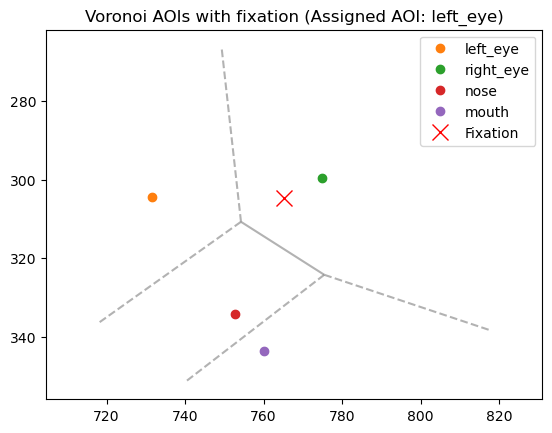

In [18]:
# Select the first row
row = matched_df.iloc[27]

# Calculate mouth center
mouth_x, mouth_y = mouth_centre(
    row['mouth left x [px]'], row['mouth left y [px]'],
    row['mouth right x [px]'], row['mouth right y [px]']
)

# Define AOI centers
aoi_centers = {
    'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
    'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
    'nose': (row['nose x [px]'], row['nose y [px]']),
    'mouth': (mouth_x, mouth_y)
}

# Convert AOI centers to array
points = np.array(list(aoi_centers.values()))
labels = list(aoi_centers.keys())

# Compute Voronoi diagram
vor = Voronoi(points)

# Plot
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', line_width=1.5, line_alpha=0.6, point_size=10)

# Plot AOI points with labels
for label, (x, y) in aoi_centers.items():
    ax.plot(x, y, 'o', label=label)

# Plot fixation point
fix_x = row['fixation x [px]']
fix_y = row['fixation y [px]']
ax.plot(fix_x, fix_y, 'rx', markersize=12, label='Fixation')

ax.set_title(f"Voronoi AOIs with fixation (Assigned AOI: {assigned_aois[0]})")
ax.legend()
plt.gca().invert_yaxis()  # invert Y for image coordinate alignment
plt.axis('equal')
plt.show()


In [19]:
matched_df[15:30]

,section id_x,recording id_x,fixation id_x,start timestamp [ns],end timestamp [ns]_x,duration [ms],fixation x [px],fixation y [px],azimuth [deg],elevation [deg],...,eye left y [px],eye right x [px],eye right y [px],nose x [px],nose y [px],mouth left x [px],mouth left y [px],mouth right x [px],mouth right y [px],assigned_aoi
15,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,993,1743586574966432504,1743586575056432504,90,1298.225,212.679,32.593498,23.992578,...,177.727,1329.903,193.572,1243.936,269.524,1212.632,319.564,1301.756,333.731,right_eye
16,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,994,1743586575176557504,1743586575436807504,260,978.293,428.810,10.200974,11.368931,...,387.916,1068.096,397.157,994.681,480.299,978.154,506.625,1062.647,513.769,left_eye
17,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,995,1743586575466807504,1743586575762057504,295,975.051,465.369,9.945503,9.042386,...,468.209,985.726,465.687,930.130,550.771,922.764,569.505,998.289,566.992,right_eye
18,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,1082,1743586602852315504,1743586603022446504,170,821.889,223.115,0.040372,24.565312,...,247.514,843.097,245.374,826.964,267.882,803.810,271.848,825.724,271.143,left_eye
19,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,1083,1743586603057565504,1743586603137565504,80,802.110,281.978,-1.286263,20.813377,...,285.254,828.567,282.277,812.068,303.746,793.610,305.568,815.767,303.959,left_eye
20,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,1086,1743586605139451504,1743586605239568504,100,1213.888,290.679,26.175629,19.560532,...,298.439,1245.376,305.417,1222.953,321.521,1208.405,336.635,1234.764,342.254,left_eye
21,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,1088,1743586606035316504,1743586607892067504,1857,964.508,319.078,9.499090,18.359745,...,293.264,1009.948,292.305,987.418,312.578,976.566,331.974,1007.204,331.065,nose
22,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,1089,1743586608037191504,1743586608332442504,295,940.353,306.509,7.922420,19.186660,...,286.439,949.090,286.899,924.821,307.198,916.404,325.471,947.210,325.628,nose
23,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,1090,1743586608357442504,1743586608847942504,490,932.089,289.679,7.404945,20.265348,...,291.990,937.459,291.920,915.310,317.295,906.505,329.664,938.360,329.071,right_eye
24,93afe80b-ae7f-4f8c-a9b1-ff64ec737be7,cb50f848-da60-46a7-9861-e33392224304,1091,1743586608958077504,1743586609173192504,215,893.879,289.245,4.852428,20.326917,...,308.772,905.600,306.155,885.028,333.277,876.483,346.376,909.006,343.590,right_eye


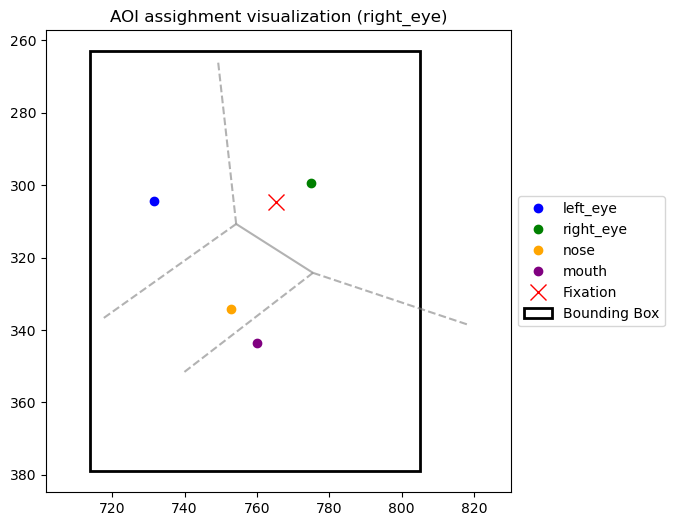

In [20]:
# Select the first row
row = matched_df.iloc[27]

# Calculate mouth center
mouth_x, mouth_y = mouth_centre(
    row['mouth left x [px]'], row['mouth left y [px]'],
    row['mouth right x [px]'], row['mouth right y [px]']
)

# Define AOI centers with colors
aoi_centers = {
    'left_eye': ((row['eye left x [px]'], row['eye left y [px]']), 'blue'),
    'right_eye': ((row['eye right x [px]'], row['eye right y [px]']), 'green'),
    'nose': ((row['nose x [px]'], row['nose y [px]']), 'orange'),
    'mouth': ((mouth_x, mouth_y), 'purple')
}

# Convert AOI coords to array for Voronoi
points = np.array([coords for coords, _ in aoi_centers.values()])

# Create Voronoi diagram
vor = Voronoi(points)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', line_width=1.5, line_alpha=0.6, point_size=0)

# Plot AOI points with different colors
for label, ((x, y), color) in aoi_centers.items():
    ax.plot(x, y, 'o', color=color, label=label)

# Plot fixation point
fix_x = row['fixation x [px]']
fix_y = row['fixation y [px]']
ax.plot(fix_x, fix_y, 'rx', markersize=12, label='Fixation')

# Draw bounding box from p1 (top-left) to p2 (bottom-right)
x1 = row['p1 x [px]']
y1 = row['p1 y [px]']
x2 = row['p2 x [px]']
y2 = row['p2 y [px]']
bbox_w = x2 - x1
bbox_h = y2 - y1
rect = plt.Rectangle((x1, y1), bbox_w, bbox_h, linewidth=2, edgecolor='black', facecolor='none', label='Bounding Box')
ax.add_patch(rect)

# Add legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set title and display
ax.set_title(f"AOI assighment visualization ({assigned_aois[27]})")
plt.gca().invert_yaxis()
plt.axis('equal')
#plt.tight_layout()
plt.show()


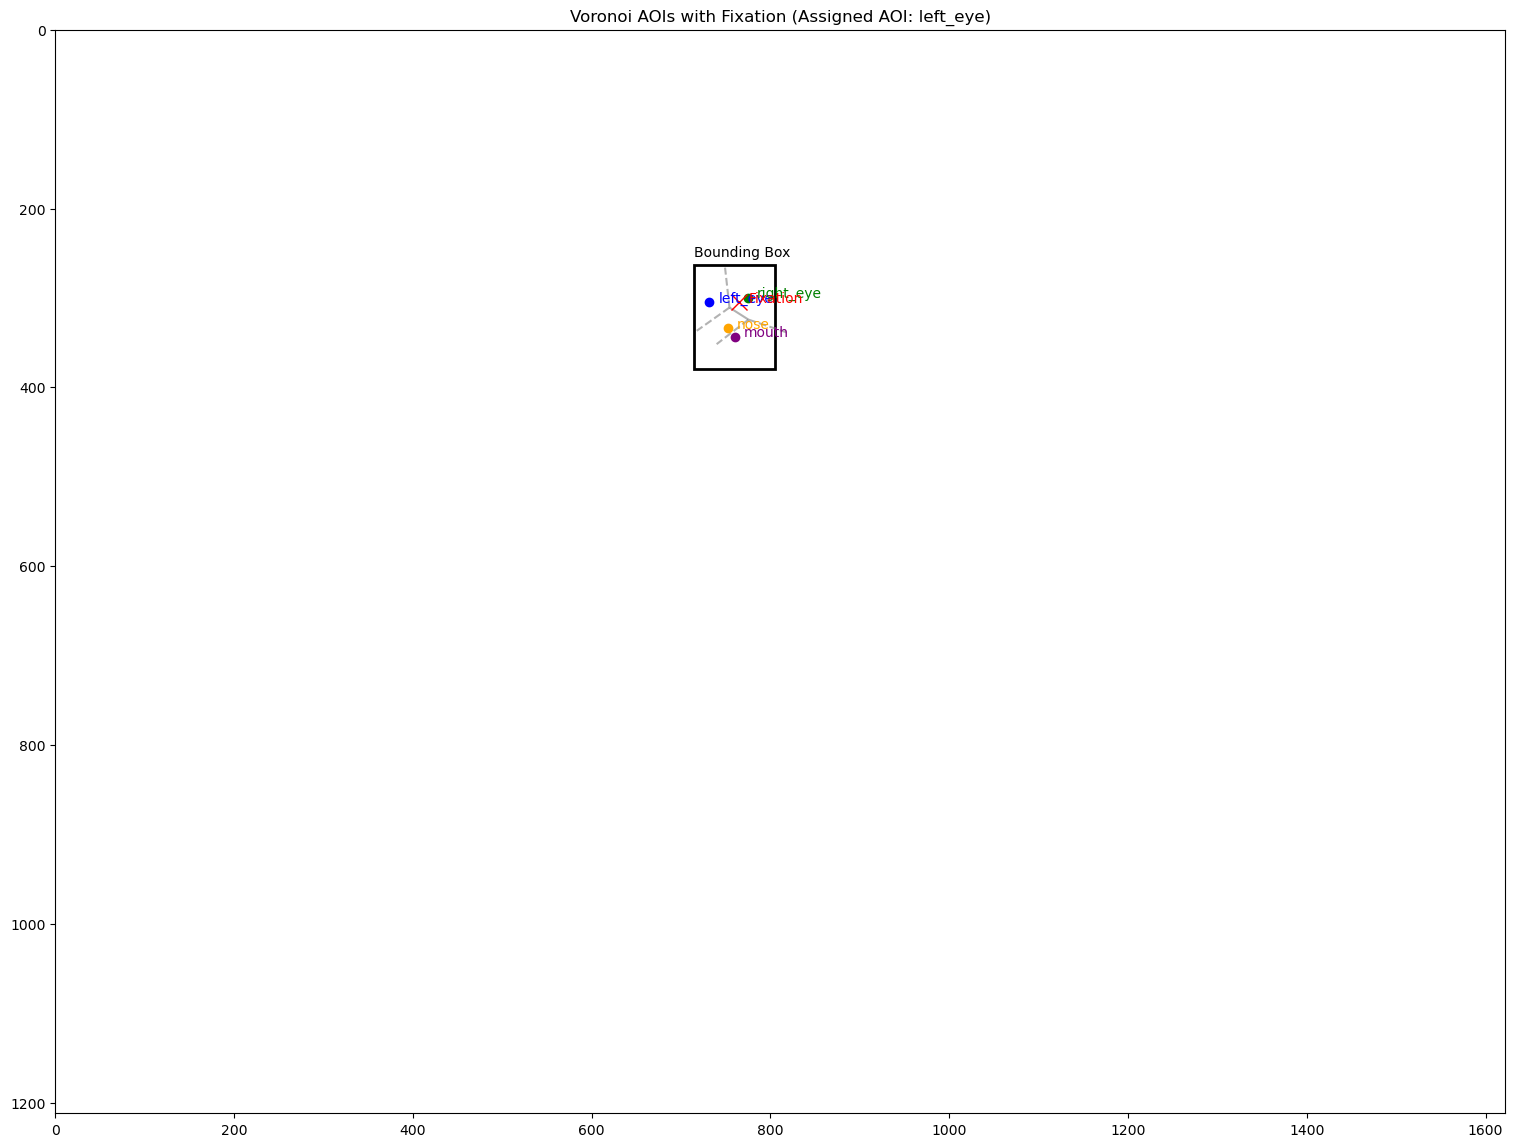

In [21]:
fig, ax = plt.subplots(figsize=(20, 15))

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray',
                line_width=1.5, line_alpha=0.6, point_size=0)


# Plot AOIs
for label, ((x, y), color) in aoi_centers.items():
    ax.plot(x, y, 'o', color=color)
    ax.text(x + 10, y, label, fontsize=10, color=color)  # Label slightly offset

# Plot fixation
ax.plot(fix_x, fix_y, 'rx', markersize=12)
ax.text(fix_x + 10, fix_y, 'Fixation', fontsize=10, color='red')

# Bounding box
rect = plt.Rectangle((x1, y1), bbox_w, bbox_h, linewidth=2,
                     edgecolor='black', facecolor='none')
ax.add_patch(rect)
ax.text(x1, y1 - 10, 'Bounding Box', fontsize=10, color='black')

# Coordinate fix
ax.set_xlim(0, 1622)
ax.set_ylim(0, 1212)
ax.set_aspect('equal')
plt.gca().invert_yaxis()
plt.title(f"Voronoi AOIs with Fixation (Assigned AOI: {assigned_aois[1]})")
plt.subplots_adjust(right=0.85)
plt.show()


### Statistics ###

In [71]:
#matched_df.info()

In [60]:
### leaving only needed columns

face_landmarks_df = matched_df[['fixation id_x', 'start timestamp [ns]', 'duration [ms]', 'assigned_aoi']]

face_landmarks_df.rename(columns={'fixation id_x': 'fixation id'})

face_landmarks_df.to_csv(os.path.join(recording_path, f"face_landmarks{participant_number}_{recording_number}.csv"))

In [65]:
face_landmarks_df
saving_path = os.path.join(recording_path, f"face_landmarks_{participant_number}_{recording_number}.csv")
face_landmarks_df.to_csv(saving_path, index=False)

assigned_aoi
right_eye    61
mouth        51
nose         49
left_eye     47
Name: count, dtype: int64


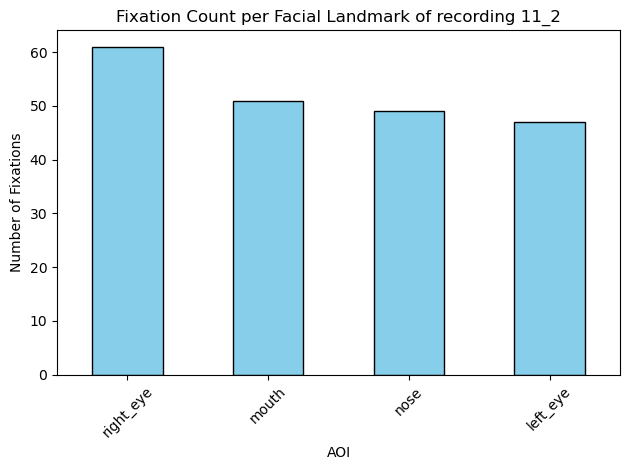

In [71]:
# Count each unique AOI assignment
aoi_counts = face_landmarks_df['assigned_aoi'].value_counts()

# Print counts (optional)
print(aoi_counts)

# Plot histogram
aoi_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f'Fixation Count per Facial Landmark of recording {participant_number}_{recording_number}')
plt.xlabel('AOI')
plt.ylabel('Number of Fixations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## For all participants ##

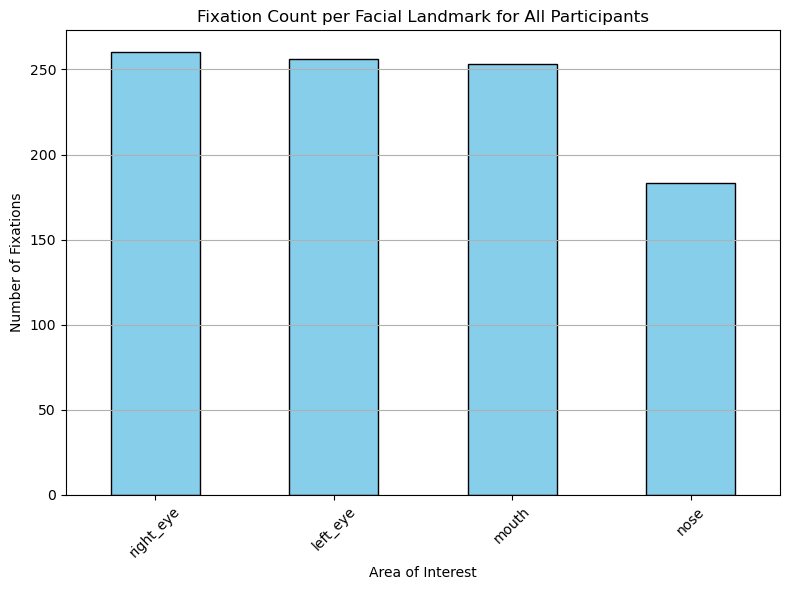

In [51]:
base_path = "/Users/alina/Downloads/Thesis/raw/"

# Define your helper functions: filter_by_intervals, mouth_centre, which_aoi

def process_recording(participant_number, recording_number, recording_path, result_df, aoi_assignments_df):
    try:
        # Define file paths
        events_file = os.path.join(recording_path, "events.csv")
        face_detections_file = os.path.join(recording_path, "face_detections.csv")
        fixations_file = os.path.join(recording_path, "fixations.csv")
        face_file = os.path.join(recording_path, "fixations_on_face.csv")

        # Load data
        events_df = pd.read_csv(events_file)
        face_detections_df = pd.read_csv(face_detections_file)
        fixations_df = pd.read_csv(fixations_file)
        face_df = pd.read_csv(face_file)

        def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
            filter = pd.Series(False, index=df.index)  # start with all False

            for start, end in intervals:
                filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

            return df[filter]

        ## to filter each file by leaving only experiment timestamps
        events_df = events_df.sort_values("timestamp [ns]")
        A_events = events_df[events_df["name"] == "A"]
        B_events = events_df[events_df["name"] == "B"]
        C_events = events_df[events_df["name"] == "C"]
        D_events = events_df[events_df["name"] == "D"]

        max_timestamp_A = A_events["timestamp [ns]"].max()
        min_timestamp_B = B_events["timestamp [ns]"].min()
        max_timestamp_B = B_events["timestamp [ns]"].max()
        min_timestamp_C = C_events["timestamp [ns]"].min()
        max_timestamp_C = C_events["timestamp [ns]"].max()
        min_timestamp_D = D_events["timestamp [ns]"].min()

        intervals = [
            (max_timestamp_A, min_timestamp_B),
            (max_timestamp_B, min_timestamp_C),
            (max_timestamp_C, min_timestamp_D)
        ]

        # Apply filtering
        face_detections_df = filter_by_intervals(face_detections_df, intervals, timestamp_col='timestamp [ns]')
        fixations_df = filter_by_intervals(fixations_df, intervals, timestamp_col='start timestamp [ns]')
        face_df = filter_by_intervals(face_df, intervals, timestamp_col='start timestamp [ns]')

        # Merge fixations on face
        face_with_coordinates_df = pd.merge(
            fixations_df,
            face_df,
            on="start timestamp [ns]",
            how="inner"
        )
        face_with_coordinates_df = face_with_coordinates_df[face_with_coordinates_df['fixation on face'] == True]

        # Matching fixations with detections
        matched_rows = []
        unmatched_fixations = 0
        face_detections_df['timestamp [ns]'] = face_detections_df['timestamp [ns]'].astype(int)
        unique_timestamps = face_detections_df['timestamp [ns]'].sort_values().unique()

        for _, fixation_row in face_with_coordinates_df.iterrows():
            ts_start = fixation_row['start timestamp [ns]']
            ts_end = fixation_row['end timestamp [ns]_x']
            fx = fixation_row['fixation x [px]']
            fy = fixation_row['fixation y [px]']

            timestamps_in_interval = unique_timestamps[(unique_timestamps >= ts_start) & (unique_timestamps <= ts_end)]

            found = False
            for ts in timestamps_in_interval:
                detections_at_ts = face_detections_df[face_detections_df['timestamp [ns]'] == ts]

                for _, det_row in detections_at_ts.iterrows():
                    x1, y1 = det_row['p1 x [px]'], det_row['p1 y [px]']
                    x2, y2 = det_row['p2 x [px]'], det_row['p2 y [px]']

                    if x1 <= fx <= x2 and y1 <= fy <= y2:
                        combined = {**fixation_row.to_dict(), **det_row.to_dict()}
                        matched_rows.append(combined)
                        found = True
                        break
                if found:
                    break

            if not found:
                unmatched_fixations += 1

        # AOI assignment
        matched_df = pd.DataFrame(matched_rows)
        assigned_aois = []
        fixation_ids = []
        start_timestamps = []
        durations = []

        for _, row in matched_df.iterrows():

            st_ts = row['start timestamp [ns]']
            fix_id = row['fixation id_x']
            duration = row['duration [ms]']

            mouth_x, mouth_y = mouth_centre(
                row['mouth left x [px]'], row['mouth left y [px]'],
                row['mouth right x [px]'], row['mouth right y [px]']
            )

            aoi_centers = {
                'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
                'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
                'nose': (row['nose x [px]'], row['nose y [px]']),
                'mouth': (mouth_x, mouth_y)
            }

            assigned_aoi = which_aoi(row['fixation x [px]'], row['fixation y [px]'], aoi_centers)
            assigned_aois.append(assigned_aoi)
            start_timestamps.append(st_ts)
            fixation_ids.append(fix_id)
            durations.append(duration)

        # Create a DataFrame for the assigned AOIs
        aoi_assignments_df = pd.concat([aoi_assignments_df, pd.DataFrame({
            'Participant': [participant_number] * len(assigned_aois),
            'Recording': [recording_number] * len(assigned_aois),
            'assigned_aoi': assigned_aois,
            'start timestamp [ns]': start_timestamps,
            'fixation_id': fixation_ids,
            'duration (ms)': durations
        })], ignore_index=True)


        # Add results to the result DataFrame using pd.concat
        result_df = pd.concat([result_df, pd.DataFrame([{
            'Participant': participant_number,
            'Recording': recording_number,
            'total_fixations': len(face_with_coordinates_df),
            'matched_fixations': len(matched_rows),
            'unmatched_fixations': unmatched_fixations
        }])], ignore_index=True)

    except Exception as e:
        print(f"Error processing Participant {participant_number}, Recording {recording_number}: {e}")
    return result_df, aoi_assignments_df


# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Participant', 'Recording', 'total_fixations', 'matched_fixations', 'unmatched_fixations'])

# Initialize an empty DataFrame to store AOI assignments
aoi_assignments_df = pd.DataFrame(columns=['Participant', 'Recording', 'start timestamp [ns]','fixation_id', 'assigned_aoi', 'duration (ms)'])

# Scan all participants and recordings
for participant_folder in os.listdir(base_path):
    if participant_folder.startswith("Participant"):
        participant_number = participant_folder.split()[-1]
        folder_path = os.path.join(base_path, participant_folder)

        for recording_folder in os.listdir(folder_path):
            if recording_folder.startswith(f"P{participant_number}_"):
                recording_number = recording_folder.split("_")[-1]
                recording_path = os.path.join(folder_path, recording_folder)
                results_df, aoi_assignments_df = process_recording(participant_number, recording_number, recording_path, results_df, aoi_assignments_df)

# Optionally, save results to a CSV file
# results_df.to_csv('results.csv', index=False)

# Count number of fixations for each AOI
aoi_counts = aoi_assignments_df['assigned_aoi'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
aoi_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Fixation Count per Facial Landmark for All Participants')
plt.xlabel('Area of Interest')
plt.ylabel('Number of Fixations')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [49]:
matched_df

,section id_x,recording id_x,fixation id_x,start timestamp [ns],end timestamp [ns]_x,duration [ms],fixation x [px],fixation y [px],azimuth [deg],elevation [deg],...,eye left y [px],eye right x [px],eye right y [px],nose x [px],nose y [px],mouth left x [px],mouth left y [px],mouth right x [px],mouth right y [px],assigned_aoi
0,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,422,1742392768943866145,1742392769214116145,270,1250.033,321.128,28.363992,17.568863,...,313.635,1260.885,313.625,1257.225,319.018,1253.792,322.380,1259.544,322.284,mouth
1,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,533,1742392809221369145,1742392809331494145,110,558.334,355.754,-17.277828,15.842578,...,350.183,569.391,350.517,568.566,354.605,564.517,357.517,567.443,358.071,mouth
2,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,536,1742392810117244145,1742392810597624145,480,996.631,249.703,11.848567,22.706977,...,254.238,1075.005,238.125,1046.412,290.389,1026.560,328.719,1084.991,315.632,left_eye
3,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,537,1742392810632744145,1742392810897997145,265,1036.270,293.338,14.341961,19.872838,...,226.796,1063.403,237.080,1017.618,278.155,986.231,308.504,1049.186,317.364,nose
4,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,538,1742392811058119145,1742392811143244145,85,1012.408,233.436,12.980010,23.704605,...,220.269,1064.112,224.294,1024.431,265.654,988.660,297.513,1057.363,300.771,left_eye
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,6474,1742395000313918145,1742395000579167145,265,1018.647,333.766,13.039686,17.350570,...,183.326,1094.298,152.380,985.188,324.440,953.203,405.097,1116.908,379.205,nose
204,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,6491,1742395006324422145,1742395006479547145,155,918.336,268.745,6.523959,21.610431,...,239.432,907.179,239.017,896.615,251.260,902.806,262.681,906.499,262.155,mouth
205,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,6528,1742395021113182145,1742395021508557145,395,714.207,398.715,-6.994709,13.325480,...,81.086,1041.480,130.684,963.186,214.853,836.970,260.421,970.824,301.240,mouth
206,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,6529,1742395021898932145,1742395023555433145,1657,927.949,419.091,6.941939,12.026627,...,170.490,1038.250,210.336,942.654,334.153,808.728,339.979,951.810,376.073,mouth


In [53]:
saving_path = os.path.join(base_path, f"face_landmarks_all_participants.csv")
aoi_assignments_df.to_csv(saving_path, index=False)


In [52]:
aoi_assignments_df #sort for participant and recording number

,Participant,Recording,start timestamp [ns],fixation_id,assigned_aoi,duration (ms)
0,09,2,1742396388168520066,299,mouth,215
1,09,2,1742396455526286066,466,right_eye,245
2,09,2,1742396463713915066,493,mouth,185
3,09,2,1742396533598963066,679,mouth,530
4,09,2,1742396574507130066,809,mouth,140
...,...,...,...,...,...,...
947,11,2,1743163037784034864,7225,left_eye,435
948,11,2,1743163038259409864,7226,left_eye,280
949,11,2,1743163039250409864,7229,mouth,180
950,11,2,1743163041982909864,7238,left_eye,1832


In [45]:
print(aoi_counts)

Series([], Name: count, dtype: int64)


In [37]:
results_df
save_path = os.path.join(base_path, f"umatched face fixations.csv")
results_df.to_csv(save_path, index=False)